In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import utils, Modelling, dataset_module, Train_Test

In [27]:
class ModelEvaluator:
    
    def __init__(self, input_dataset, trainset,  model):

        assert isinstance(input_dataset, pd.DataFrame)
        assert isinstance(trainset, dataset_module.DataSetForImputation)
        assert isinstance(model, Modelling.DenoisingAutoEncoder)

        RANDOM_SEED = 18
        np.random.seed(RANDOM_SEED)
        if torch.cuda.is_available():
            device = 'cuda'
            torch.cuda.manual_seed(RANDOM_SEED)
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
            kwargs = {'num_workers': 4, 'pin_memory': True}
        else:
            device = 'cpu'
            torch.manual_seed(RANDOM_SEED)
            torch.set_default_tensor_type(torch.FloatTensor)
            kwards = {}

        self.complete_dataset = input_dataset.copy() # No NaNs

        self.sampled_dataset, _ = train_test_split(self.complete_dataset, test_size = 0.1) # 90% of the complete dataset is used
        self.dataset_for_models = self.sampled_dataset.copy()  # introduce NaNs here
        self.dataset_for_models = utils.induce_missingness(self.dataset_for_models) # half the variables, 20% missing data

        self.model = model.eval()
        self.evaluated_dataset = Train_Test.test_model(net=self.model, test_df=self.dataset_for_models,
                                                       trainset=trainset, device=device,
                                                       logger_level=20) # All NaNs filled (only imputed values are filled)
    @staticmethod
    def fitter(dataframe):
        """Fit a Linear Regression model using all variables of the dataframe

        Returns all the co-efficients
        """
        assert isinstance(dataframe, pd.DataFrame)

        from sklearn.linear_model import LinearRegression

        fitting_model = LinearRegression().fit(dataframe.iloc[:, :-1], dataframe.iloc[:,-1])
        co_eff = fitting_model.coef_
        co_eff = (co_eff - co_eff.min()) / (co_eff.max() - co_eff.min())
        return co_eff

    def plot_evaluation(self, data_to_be_compared = None, title = None, xlabel = "Regression params from Imputed data", annotation = True):
        
        y = ModelEvaluator.fitter(self.complete_dataset)
        x = ModelEvaluator.fitter(data_to_be_compared)

        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        ax.set_title(title)
        ax.set_ylabel("Regression params from Original data")
        ax.set_xlabel(xlabel)
        plt.scatter(x, y, label = "Parameter comparison")
        if annotation:
            plt.annotate(title.split()[-1], xy=(0.1, 0.9), xycoords='axes fraction') #Dataset
        
        lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()])] # max of both axes
        
        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
               
        plt.show()


INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.98
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.69


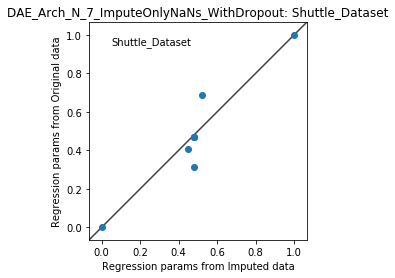

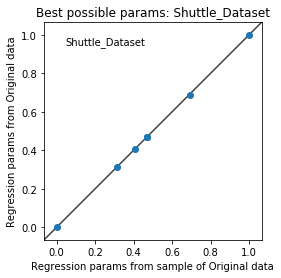

In [29]:
# Shuttle
# 1
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/shuttle/shuttle_trn"
    
    df = utils.get_dataframe_from_csv(filename).iloc[:, :-1]  # remove label
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=7, input_dropout=0.5)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/shuttle_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Shuttle_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Shuttle_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.98
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.69


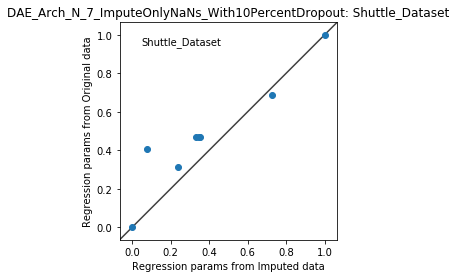

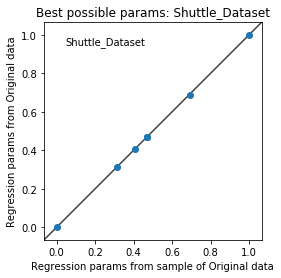

In [30]:
# Shuttle
# 2
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/shuttle/shuttle_trn"
    
    df = utils.get_dataframe_from_csv(filename).iloc[:, :-1]  # remove label
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_With10PercentDropout"
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=7, input_dropout=0.1)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/shuttle_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Shuttle_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Shuttle_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.98
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.69


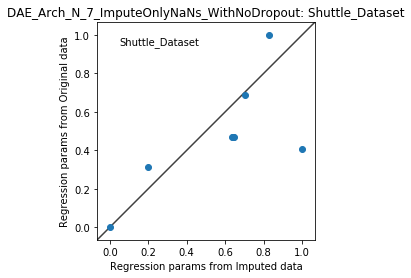

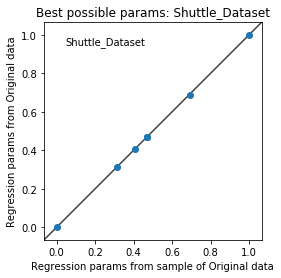

In [31]:
# Shuttle
# 3
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/shuttle/shuttle_trn"
    
    df = utils.get_dataframe_from_csv(filename).iloc[:, :-1]  # remove label
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithNoDropout"
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=7, input_dropout=0.0)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/shuttle_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Shuttle_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Shuttle_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.98
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.69


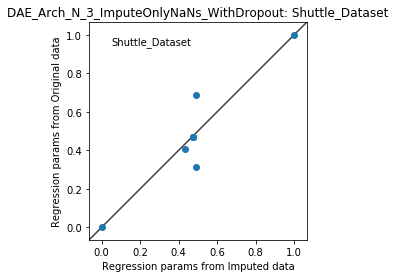

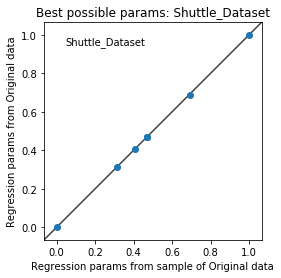

In [33]:
# Shuttle
# 4
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/shuttle/shuttle_trn"
    
    df = utils.get_dataframe_from_csv(filename).iloc[:, :-1]  # remove label
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "DAE_Arch_N_3_ImputeOnlyNaNs_WithDropout"
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=3, input_dropout=0.5)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/shuttle_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Shuttle_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Shuttle_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.98
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.69


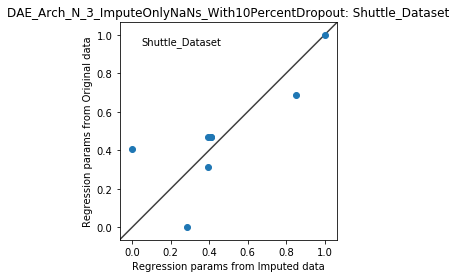

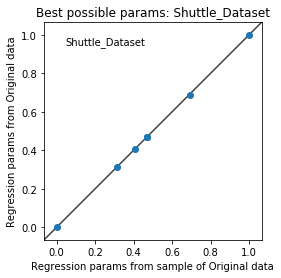

In [34]:
# Shuttle
# 5
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/shuttle/shuttle_trn"
    
    df = utils.get_dataframe_from_csv(filename).iloc[:, :-1]  # remove label
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "DAE_Arch_N_3_ImputeOnlyNaNs_With10PercentDropout"
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=3, input_dropout=0.1)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/shuttle_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Shuttle_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Shuttle_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.98
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.69


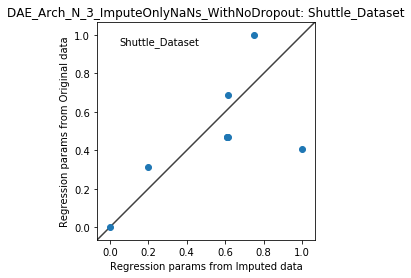

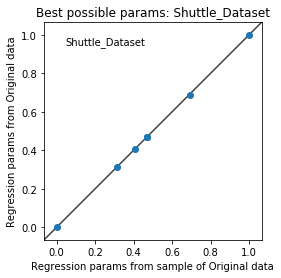

In [35]:
# Shuttle
# 6
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/shuttle/shuttle_trn"
    
    df = utils.get_dataframe_from_csv(filename).iloc[:, :-1]  # remove label
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "DAE_Arch_N_3_ImputeOnlyNaNs_WithNoDropout"
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=3, input_dropout=0.0)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/shuttle_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Shuttle_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Shuttle_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.98
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.69


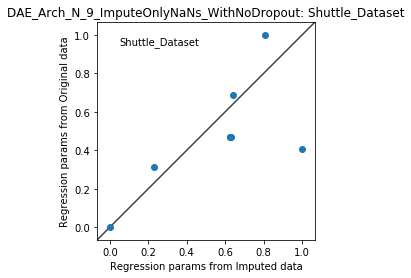

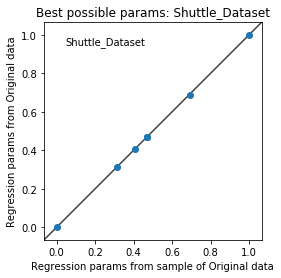

In [36]:
# Shuttle
# 7
if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/shuttle/shuttle_trn"
    
    df = utils.get_dataframe_from_csv(filename).iloc[:, :-1]  # remove label
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "DAE_Arch_N_9_ImputeOnlyNaNs_WithNoDropout"
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=9, input_dropout=0.0)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/shuttle_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Shuttle_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Shuttle_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

## Box Plot comparison

In [ ]:
class ModelEvaluator:
    
    def __init__(self, input_dataset, trainset,  model):

        assert isinstance(input_dataset, pd.DataFrame)
        assert isinstance(trainset, dataset_module.DataSetForImputation)
        assert isinstance(model, Modelling.DenoisingAutoEncoder)

        RANDOM_SEED = 18
        np.random.seed(RANDOM_SEED)
        if torch.cuda.is_available():
            device = 'cuda'
            torch.cuda.manual_seed(RANDOM_SEED)
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
            kwargs = {'num_workers': 4, 'pin_memory': True}
        else:
            device = 'cpu'
            torch.manual_seed(RANDOM_SEED)
            torch.set_default_tensor_type(torch.FloatTensor)
            kwards = {}

        self.complete_dataset = input_dataset.copy() # No NaNs

        self.sampled_dataset, _ = train_test_split(self.complete_dataset, test_size = 0.1) # 90% of the complete dataset is used
        self.dataset_for_models = self.sampled_dataset.copy()  # introduce NaNs here
        self.dataset_for_models = utils.induce_missingness(self.dataset_for_models) # half the variables, 20% missing data

        self.model = model.eval()
        self.evaluated_dataset = Train_Test.test_model(net=self.model, test_df=self.dataset_for_models,
                                                       trainset=trainset, device=device,
                                                       logger_level=20) # All NaNs filled (only imputed values are filled)
    @staticmethod
    def fitter(dataframe):
        """Fit a Linear Regression model using all variables of the dataframe

        Returns all the co-efficients
        """
        assert isinstance(dataframe, pd.DataFrame)

        from sklearn.linear_model import LinearRegression

        fitting_model = LinearRegression().fit(dataframe.iloc[:, :-1], dataframe.iloc[:,-1])
        co_eff = fitting_model.coef_
        co_eff = (co_eff - co_eff.min()) / (co_eff.max() - co_eff.min())
        return co_eff

    def plot_evaluation(self, data_to_be_compared = None, title = None, xlabel = "Regression params from Imputed data", annotation = True):
        
        y = ModelEvaluator.fitter(self.complete_dataset)
        x = ModelEvaluator.fitter(data_to_be_compared)

        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        ax.set_title(title)
        ax.set_ylabel("Regression params from Original data")
        ax.set_xlabel(xlabel)
        plt.scatter(x, y, label = "Parameter comparison")
        if annotation:
            plt.annotate(title.split()[-1], xy=(0.1, 0.9), xycoords='axes fraction') #Dataset
        
        lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()])] # max of both axes
        
        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
               
        plt.show()

INFO:root:Input filename has to be space separated data
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.98
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs
INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 8.69


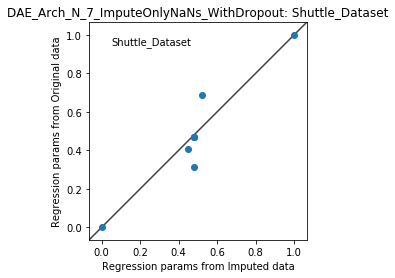

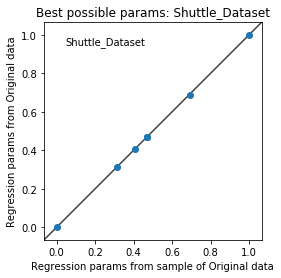

In [39]:

if __name__ == '__main__':
    
    #Provide Dataset
    filename = "data/shuttle/shuttle_trn"
    
    df = utils.get_dataframe_from_csv(filename).iloc[:, :-1]  # remove label
    train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df.copy(), test_perc=0.3, logger_level=20) # full_test_df is test_df but has no NaNs
    input_dataset = full_test_df
    trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  # normalize True for [0,1] normalization for dataframe

    #Provide Model Name
    model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"
    #Provide Model Details
    model = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta=7, input_dropout=0.5)
    #Provide Saved location
    model.load_state_dict(torch.load(f"./Results/shuttle_results/{model_name}/artifacts/saved_model/model_at_epoch100"))
    
    #Print Details
    model_eval = ModelEvaluator(input_dataset, trainset,  model)
    model_eval.plot_evaluation(title = model_name+": Shuttle_Dataset", data_to_be_compared = model_eval.evaluated_dataset, xlabel = "Regression params from Imputed data" )
    model_eval.plot_evaluation(title ="Best possible params:"+" Shuttle_Dataset", data_to_be_compared = model_eval.sampled_dataset, xlabel = "Regression params from sample of Original data" )    

In [37]:
test_mason= model_eval.evaluated_dataset

In [42]:
test_mason.head()

,50,21,77,0,28,0.1,27,48,22
0,55,70.714351,82,0,54,-4,37.352457,59.812748,3.223528
1,49,76.992312,81,0,50,18,37.582026,61.393863,3.971832
2,42,80.414483,86,2,42,0,37.971321,66.129003,7.731663
3,37,0.000000,79,0,8,14,42.000000,71.000000,30.000000
4,44,0.000000,81,8,44,9,38.000000,37.000000,0.000000


In [106]:
def OLS_fitter(dataframe):
    """
    Fit a Linear Regression model using all variables of the dataframe
    Returns datframe with all the co-efficient estimates, errors, and Confidence Intervals/
    """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    assert isinstance(dataframe, pd.DataFrame)

    fitting_model = sm.OLS(dataframe.iloc[:,-1], dataframe.iloc[:, :-1]) # (y,x)
    results = fitting_model.fit()
    params = results.params
    params_std_err = results.bse
    
    conf_interval_lower_bound = params - 1.96*(params_std_err)
    conf_interval_upper_bound = params + 1.96*(params_std_err)
    
    results_df = pd.DataFrame(data = (params, params_std_err, conf_interval_lower_bound, conf_interval_upper_bound), index = ["Parameters","Standard_Error", "Lower_Bound_95%ConfInt", "Upper_Bound95%ConfInt"] )
    
    return results_df.transpose()

In [131]:
def OLS_estimator(dataframe):
    """
    Fit a Linear Regression model using all variables of the imputed dataset dataframe
    Returns all the co-efficient estimates of the imputed dataset
    """
    
    import statsmodels.api as sm
    import pandas as pd
    import numpy as np
    assert isinstance(dataframe, pd.DataFrame)

    fitting_model = sm.OLS(dataframe.iloc[:,-1], dataframe.iloc[:, :-1]) # (y,x)
    results = fitting_model.fit()
    params_df = pd.DataFrame(data = [results.params],index = ["Parameter_imputed"])
    
    return params_df.transpose()

In [132]:
test_chong = OLS_estimator(test_mason)

In [133]:
test_chong

,Parameter_imputed
50,0.045129
21,-0.008093
77,0.627033
0,0.000902
28,-0.628325
0.1,-0.000558
27,-0.983357
48,0.296559


In [116]:
test_garner = OLS_fitter(test_mason)

In [117]:
test_garner

,Parameters,Standard_Error,Lower_Bound_95%ConfInt,Upper_Bound95%ConfInt
50,0.045129,0.007654,0.030128,0.060130
21,-0.008093,0.000464,-0.009002,-0.007184
77,0.627033,0.008931,0.609528,0.644537
0,0.000902,0.000961,-0.000981,0.002784
28,-0.628325,0.004830,-0.637792,-0.618858
0.1,-0.000558,0.000328,-0.001201,0.000086
27,-0.983357,0.008297,-0.999619,-0.967096
48,0.296559,0.004886,0.286983,0.306135


In [119]:
test_chong

,0
50,0.045129
21,-0.008093
77,0.627033
0,0.000902
28,-0.628325
0.1,-0.000558
27,-0.983357
48,0.296559


In [63]:
test_garner[0]

50     0.045129
21    -0.008093
77     0.627033
0      0.000902
28    -0.628325
0.1   -0.000558
27    -0.983357
48     0.296559
dtype: float64

In [64]:
test_garner[1]

50     0.007654
21     0.000464
77     0.008931
0      0.000961
28     0.004830
0.1    0.000328
27     0.008297
48     0.004886
dtype: float64

In [59]:
test_fitter(test_mason)

array([0.64273883, 0.62262926, 1.        , 0.62879881, 0.22976621,
       0.62730634, 0.        , 0.80806539])